In [124]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches
import contextily as ctx
import seaborn as sns
from sklearn.cluster import KMeans


import matplotlib
import matplotlib.font_manager

from requests import get
from urllib.parse import urlparse

# For debugging purposes (fonts can be hard)
print(matplotlib.get_cachedir())

# We change fonts the hard way in this notebook...
# but you can also do this to change the default 
# font everywhere in one go:
# matplotlib.rcParams['font.family'] = "Liberation Sans Narrow"
fontname = "DejaVu Sans"

matplotlib.font_manager.FontManager().findfont(fontname, fontext='ttf', rebuild_if_missing=True)

/home/jovyan/.cache/matplotlib


'/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [3]:


def cache_data(src:str, dest:str) -> str:
    """
    
    Downloads and caches a file from the given URL if it does not already exist locally 
    or if the cached file is smaller than 250 bytes.

    Args:
        src (str): The source URL to download the file from.
        dest (str): The destination directory where the file should be stored.

    Returns:
        str: The full path to the cached or downloaded file.

    Behavior:
        - Parses the URL to extract the filename.
        - Constructs the full destination path for the file.
        - Checks if the file already exists in the destination directory and if its size 
          is at least 250 bytes.
        - If the file is not present or is too small, downloads the file from the URL 
          and saves it in the specified directory, creating directories if needed.
        - If the file is already present and meets the size condition, it skips the 
          download.

    Note:
        - The function uses the `requests` library for HTTP requests.
        - If the destination directory does not exist, it is created automatically.
    
    
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250:
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:  # write in binary
            response = get(src)
            file.write(response.content)  
            #response.content:response.content 
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data) # <- This should show the docstring you've written

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    Downloads and caches a file from the given URL if it does not already exist locally 
    or if the cached file is smaller than 250 bytes.
    
    Args:
        src (str): The source URL to download the file from.
        dest (str): The destination directory where the file should be stored.
    
    Returns:
        str: The full path to the cached or downloaded file.
    
    Behavior:
        - Parses the URL to extract the filename.
        - Constructs the full destination path for the file.
        - Checks if the file already exists in the destination directory and if its size 
          is at least 250 bytes.
        - If the file is not present or is too small, downloads the file from the URL 
          and saves it in the specified directory, creating directories if needed.
        - If the file is already present and meets the size condition, it skips the 
          download.
    
   

```
# Set download URL
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'
# your code here
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}") 
```

# Data load

```
df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False, usecols=cols)
df.info(verbose=True)
```

## listing data load 

In [4]:
# Set download URL
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

In [5]:
path = os.path.join('data','raw') # A default location to save raw data
fn   = url.split('/')[-1]         # What does this do?
print(f"Writing to: {fn}")

df = pd.read_csv(cache_data(url, os.path.join('data','raw')))
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Writing to: 20240614-London-listings.csv.gz
Found data/raw/20240614-London-listings.csv.gz locally!
Data frame is 93,481 x 75


## geo data load

In [6]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )
road =  gpd.read_file( cache_data(spath+'Roads.gpkg?raw=true', ddir) )
print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Found data/geo/Roads.gpkg locally!
Done.


## choose cols needed in listing data

In [7]:
# airbnb listing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93481 entries, 0 to 93480
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            93481 non-null  int64  
 1   listing_url                                   93481 non-null  object 
 2   scrape_id                                     93481 non-null  int64  
 3   last_scraped                                  93481 non-null  object 
 4   source                                        93481 non-null  object 
 5   name                                          93481 non-null  object 
 6   description                                   90292 non-null  object 
 7   neighborhood_overview                         46671 non-null  object 
 8   picture_url                                   93472 non-null  object 
 9   host_id                                       93481 non-null 

In [8]:
# cols for Q6 to explore
cols = ['id', 'listing_url', 'host_id', 
        'host_name', 'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 
        'latitude', 'longitude', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 
        'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 
        'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_shared_rooms',
        'review_scores_rating', 
        'reviews_per_month']
print(f"Cols contains {len(cols)} columns.")

# what the diff between ['host_listings_count'] ['host_total_listings_count']  ['calculated_host_listings_count'] 

Cols contains 32 columns.


## testing bottom and cols subset

In [9]:
testing = False


if testing:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False, nrows=10000, usecols=cols)
else:
    df = pd.read_csv(os.path.join(path,fn), 
                low_memory=False, usecols=cols)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 93,481 x 31


In [10]:
df.memory_usage(index=True, deep=True)

Index                                               132
id                                               747848
listing_url                                     9290362
host_id                                          747848
host_name                                       5939562
host_since                                      6263017
host_location                                   6400285
host_about                                     25216166
host_is_superhost                               5409964
host_listings_count                              747848
host_total_listings_count                        747848
neighbourhood_cleansed                          6303994
latitude                                         747848
longitude                                        747848
property_type                                   7094542
room_type                                       6626919
accommodates                                     747848
bathrooms                                       

## check data before clean

In [11]:
print(df.columns.to_list())

['id', 'listing_url', 'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93481 entries, 0 to 93480
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           93481 non-null  int64  
 1   listing_url                                  93481 non-null  object 
 2   host_id                                      93481 non-null  int64  
 3   host_name                                    93475 non-null  object 
 4   host_since                                   93475 non-null  object 
 5   host_location                                72289 non-null  object 
 6   host_about                                   47797 non-null  object 
 7   host_is_superhost                            93022 non-null  object 
 8   host_listings_count                          93475 non-null  float64
 9   host_total_listings_count                    93475 non-null  float64
 10

'price''host_listings_count'

# Data clean

## NA check and deal with row with problems

In [13]:
#get a summary table of Na in each column
na_counts = df.isnull().sum()
na_percentage = (df.isnull().mean() * 100).round(2)

na_summary = pd.DataFrame({'Missing Count': na_counts, 'Missing Percentage': na_percentage})

na_summary = na_summary[na_summary['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

print(na_summary)

                           Missing Count  Missing Percentage
host_about                         45684               48.87
beds                               32193               34.44
bathrooms                          32122               34.36
price                              32059               34.29
review_scores_rating               24742               26.47
reviews_per_month                  24742               26.47
host_location                      21192               22.67
bedrooms                           11681               12.50
host_is_superhost                    459                0.49
bathrooms_text                       150                0.16
host_listings_count                    6                0.01
host_since                             6                0.01
host_name                              6                0.01
host_total_listings_count              6                0.01


In [14]:
#get how many Na are in specific row
df.isnull().sum(axis=1).sort_values(ascending=False).head(20)

45832    12
13539    12
8322     12
4684     12
4801     12
7173      9
4448      9
27428     9
7420      8
80911     8
7430      8
5261      8
41471     8
69386     8
69411     8
3345      8
7413      8
30444     8
86671     8
86686     8
dtype: int64

<class 'pandas.core.series.Series'>
Have reduced data frame to: 84,702 rows and 31 columns


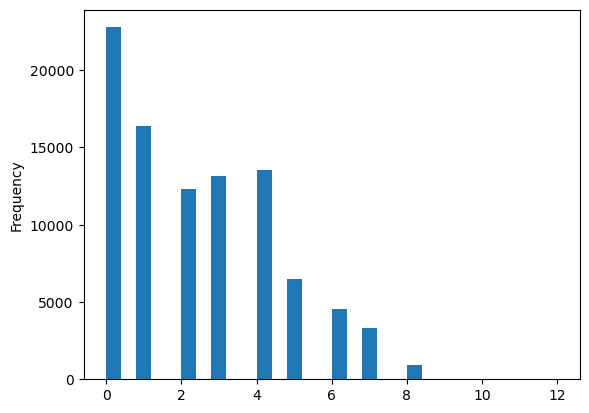

In [15]:
# store these rows to drop problem rows(with to many NA)
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 
cutoff = 5
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"Have reduced data frame to: {df.shape[0]:,} rows and {df.shape[1]:,} columns")

## Data type change

### Bool

In [16]:
# find cols should be bool but show object
bools = ['host_is_superhost']
df.sample(5, random_state=43)[bools]
# map 't' and 'f' to True and False
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


### Dates

In [17]:
# find cols should be date but show object
dates = ['host_since']
print(f"Currently {dates[0]} is of type '{df[dates[0]].dtype}'", "\n")
df.sample(5, random_state=43)[dates]

for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])
print(f"Now {dates[0]} is of type '{df[dates[0]].dtype}'", "\n")

Currently host_since is of type 'object' 

Converting host_since
Now host_since is of type 'datetime64[ns]' 



### Category

In [18]:
# find cols should be cats but show object
cats = ['property_type','room_type']

print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
df.sample(5, random_state=42)[cats]


Currently room_type is of type 'object' 



,property_type,room_type
23473,Private room in home,Private room
2944,Entire rental unit,Entire home/apt
33647,Entire rental unit,Entire home/apt
24663,Entire rental unit,Entire home/apt
16152,Entire rental unit,Entire home/apt


In [19]:
# see unique value in cols and frequency
print(df[cats[0]].value_counts())
print(df[cats[1]].value_counts())

property_type
Entire rental unit             35478
Private room in rental unit    11564
Private room in home            9796
Entire condo                    8556
Entire home                     7867
                               ...  
Hut                                1
Religious building                 1
Private room in castle             1
Private room in island             1
Private room in floor              1
Name: count, Length: 95, dtype: int64
room_type
Entire home/apt    56006
Private room       28171
Shared room          345
Hotel room           180
Name: count, dtype: int64


In [20]:
# convert dtype
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')

Converting property_type
Converting room_type


### String->

In [21]:
# convert object has numeric meaning 
money = ['price']
df.sample(5, random_state=43)[money]

,price
43988,NaN
32860,NaN
31339,$290.00
35642,$59.00
88571,$89.00


In [22]:
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','').astype('float')

Converting price


In [23]:
df.sample(5, random_state=43)[money]

,price
43988,NaN
32860,NaN
31339,290.0
35642,59.0
88571,89.0


### Integer

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84702 entries, 0 to 93480
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   id                                           84702 non-null  int64         
 1   listing_url                                  84702 non-null  object        
 2   host_id                                      84702 non-null  int64         
 3   host_name                                    84702 non-null  object        
 4   host_since                                   84702 non-null  datetime64[ns]
 5   host_location                                66602 non-null  object        
 6   host_about                                   46051 non-null  object        
 7   host_is_superhost                            84702 non-null  bool          
 8   host_listings_count                          84702 non-null  float64       
 9   

In [25]:
int64_columns = df.select_dtypes(include=['int64']).columns

print("Columns with dtype int64:")
print(int64_columns)


Columns with dtype int64:
Index(['id', 'host_id', 'accommodates', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')


In [26]:
ints  = ['id', 'host_id', 'host_listings_count', 'host_total_listings_count',
       'accommodates', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_shared_rooms']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting number_of_reviews
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting calculated_host_listings_count_shared_rooms


In [27]:
#check Na NaN
nan_counts = df[ints].isna().sum()
print(nan_counts)


id                                             0
host_id                                        0
host_listings_count                            0
host_total_listings_count                      0
accommodates                                   0
minimum_nights                                 0
maximum_nights                                 0
availability_365                               0
number_of_reviews                              0
calculated_host_listings_count                 0
calculated_host_listings_count_entire_homes    0
calculated_host_listings_count_shared_rooms    0
dtype: int64


# Final check and save clean data

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84702 entries, 0 to 93480
Data columns (total 31 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   id                                           84702 non-null  int64         
 1   listing_url                                  84702 non-null  object        
 2   host_id                                      84702 non-null  int64         
 3   host_name                                    84702 non-null  object        
 4   host_since                                   84702 non-null  datetime64[ns]
 5   host_location                                66602 non-null  object        
 6   host_about                                   46051 non-null  object        
 7   host_is_superhost                            84702 non-null  bool          
 8   host_listings_count                          84702 non-null  int64         
 9   

In [29]:
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Done.


In [30]:
df = pd.read_csv("data/clean/20240614-London-listings.csv.gz")

In [31]:
boros.crs
water.crs
green.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

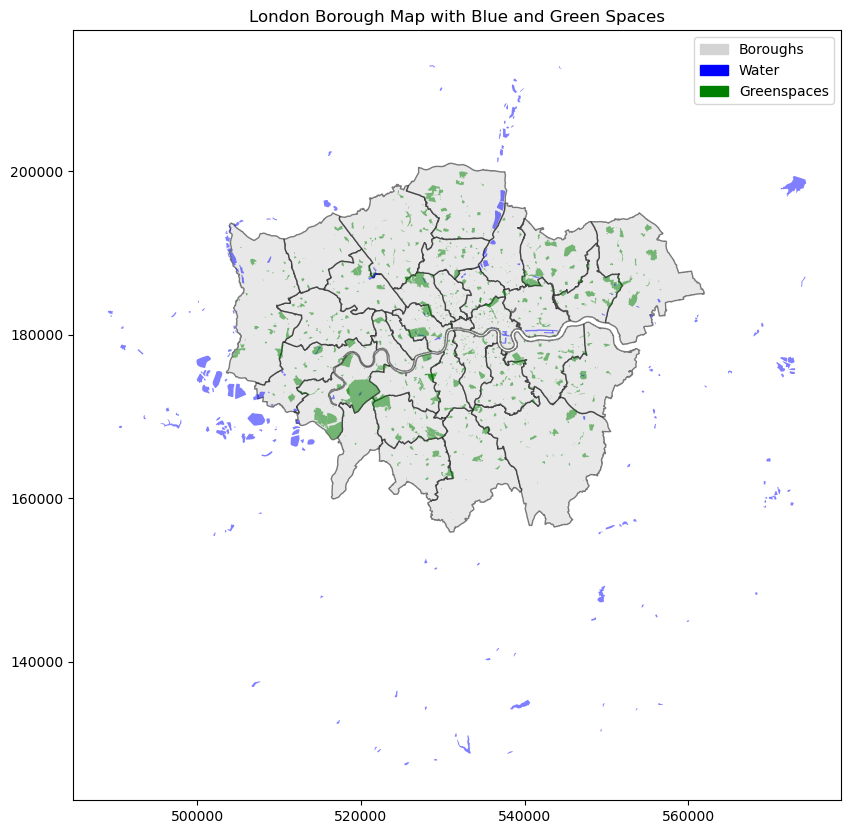

In [32]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

boros.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
water.plot(ax=ax, color = 'blue', alpha = 0.5)
green.plot(ax=ax, color = 'green', alpha = 0.5)

legend_handles = [
    mpatches.Patch(color='lightgrey', label='Boroughs'),
    mpatches.Patch(color='blue', label='Water'),
    mpatches.Patch(color='green', label='Greenspaces')]

ax.legend(handles=legend_handles)


plt.title('London Borough Map with Blue and Green Spaces')

plt.show()

In [33]:
list(boros)

boros_wo_water = boros.difference(water.union_all())
boros_wo_water_green = boros_wo_water.difference(green.union_all())

new_boros = gpd.GeoDataFrame(geometry=boros_wo_water_green, crs=boros.crs)

new_boros['area'] = new_boros.geometry.area/1000000

new_boros = new_boros.merge(boros[['NAME', 'GSS_CODE', 'HECTARES']], left_index=True, right_index=True, how='left')
new_boros = new_boros.rename(columns = {'HECTARES' : 'OLD_HECTARES'})

new_boros = new_boros[['NAME', 'GSS_CODE', 'OLD_HECTARES', 'area', 'geometry']]

print(new_boros.head())


                   NAME   GSS_CODE  OLD_HECTARES        area  \
0  Kingston upon Thames  E09000021      3726.117   36.877045   
1               Croydon  E09000008      8649.441   84.223229   
2               Bromley  E09000006     15013.487  146.182312   
3              Hounslow  E09000018      5658.541   50.729313   
4                Ealing  E09000009      5554.428   53.596711   

                                            geometry  
0  MULTIPOLYGON (((516413.3 160217.4, 516419.9 16...  
1  MULTIPOLYGON (((535002.9 159500.1, 535000.1 15...  
2  MULTIPOLYGON (((540355.2 157568.7, 540349.2 15...  
3  MULTIPOLYGON (((521961.4 178098, 521903.2 1780...  
4  POLYGON ((510247.1 182894.3, 510244.1 182902.3...  


<Axes: >

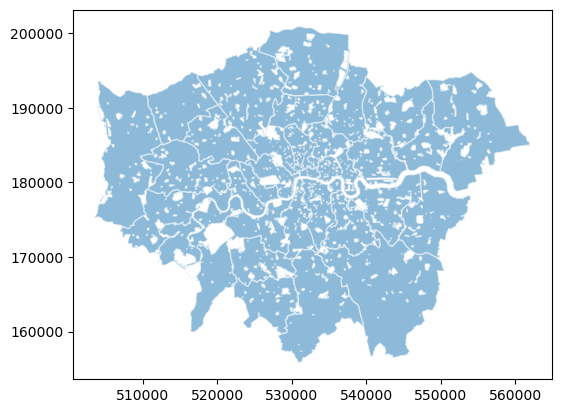

In [34]:
new_boros.plot( edgecolor='white', alpha=0.5)

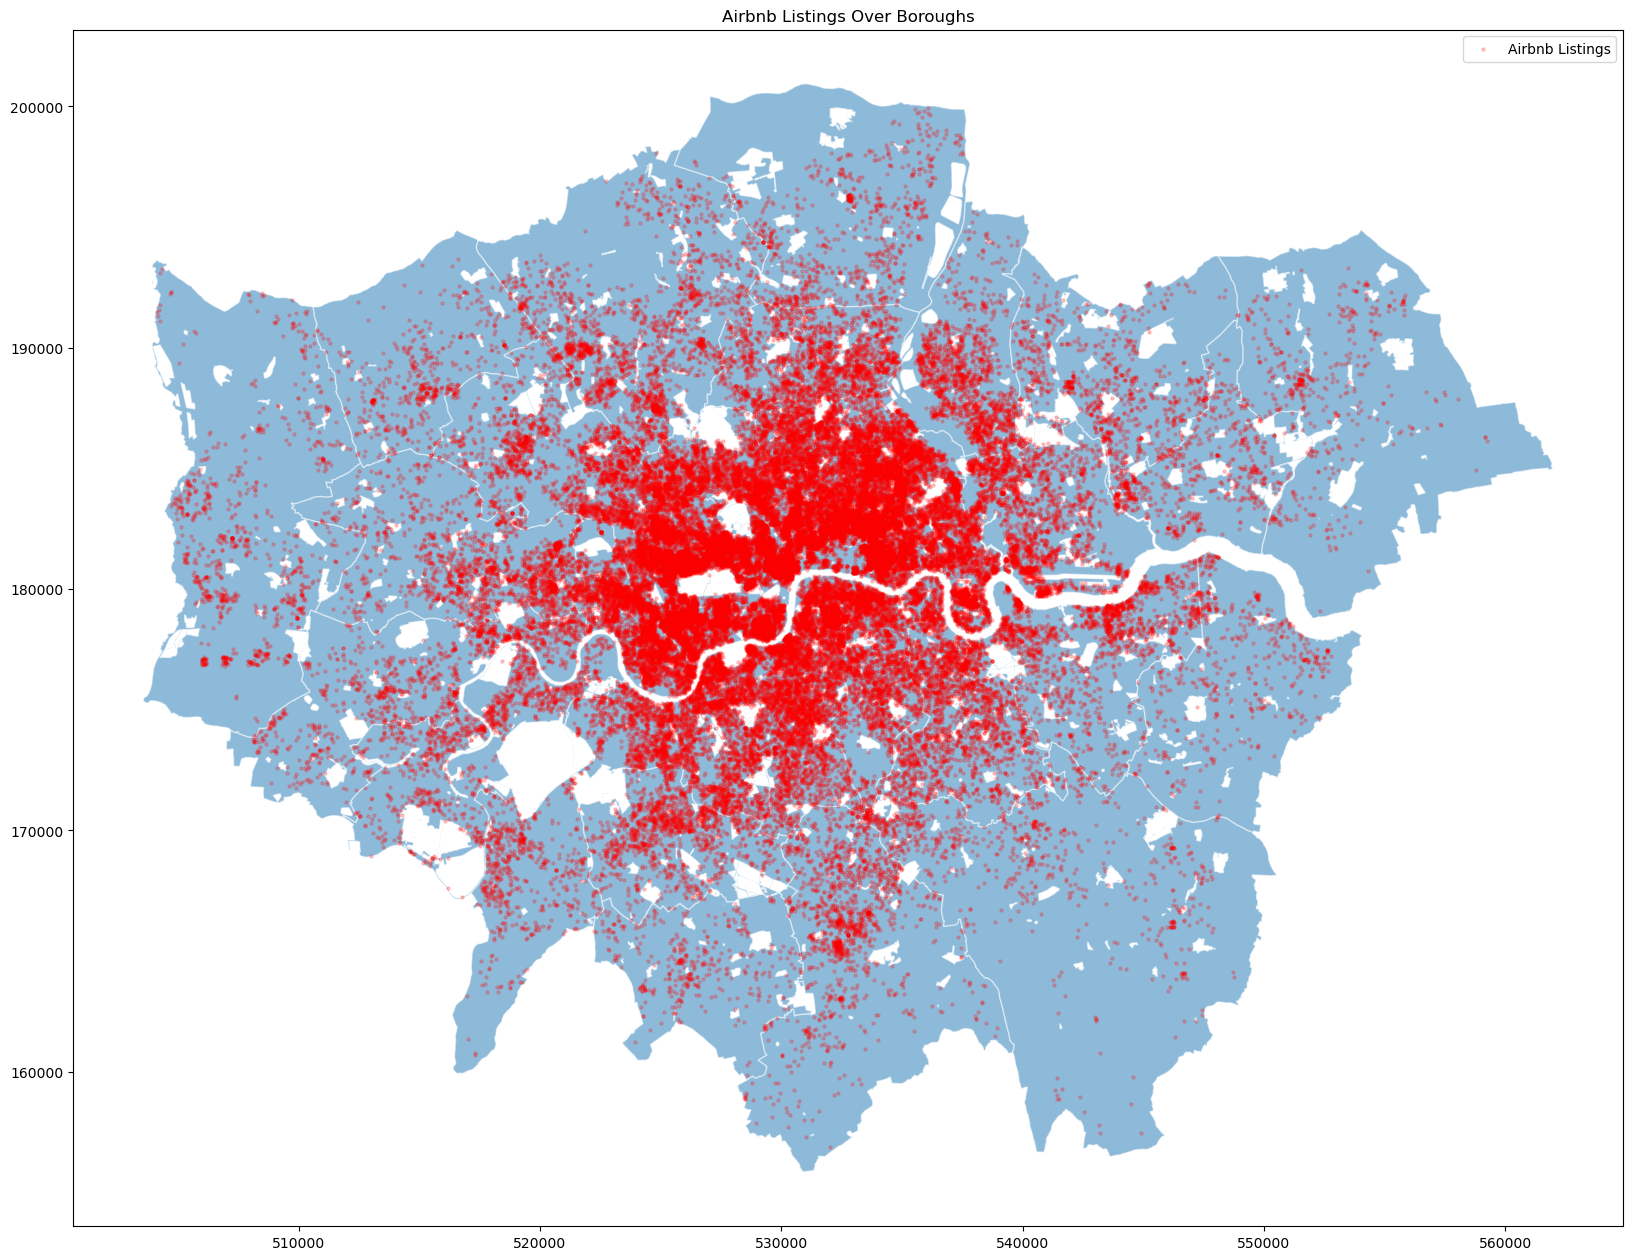

In [35]:
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
abnb = gpd.GeoDataFrame (df, geometry = geometry, crs="EPSG:4326")

if new_boros.crs != abnb.crs:
    abnb = abnb.to_crs(new_boros.crs)

fig, ax = plt.subplots(figsize=(20, 20))

new_boros.plot(ax=ax, edgecolor='white', alpha=0.5)
abnb.plot(ax=ax, color='red', markersize=5, alpha=0.2, label='Airbnb Listings')

ax.legend()

plt.title('Airbnb Listings Over Boroughs')
plt.show()

In [36]:
joined = gpd.sjoin(abnb, new_boros, how="inner", predicate="within")

listing_counts = joined.groupby('NAME').size().reset_index(name='listing_count')

new_boros = new_boros.merge(listing_counts, on='NAME', how='left')

In [58]:
list(joined)

['id',
 'listing_url',
 'host_id',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month',
 'geometry',
 'index_right',
 'NAME',
 'GSS_CODE',
 'OLD_HECTARES',
 'area']

In [37]:
print(new_boros[['NAME', 'listing_count']])

                      NAME  listing_count
0     Kingston upon Thames            615
1                  Croydon           1434
2                  Bromley            792
3                 Hounslow           1176
4                   Ealing           1970
5                 Havering            432
6               Hillingdon            812
7                   Harrow            523
8                    Brent           2634
9                   Barnet           2120
10                 Lambeth           4483
11               Southwark           4562
12                Lewisham           2350
13               Greenwich           1911
14                  Bexley            489
15                 Enfield            765
16          Waltham Forest           1711
17               Redbridge            863
18                  Sutton            378
19    Richmond upon Thames           1182
20                  Merton           1394
21              Wandsworth           4263
22  Hammersmith and Fulham        

In [38]:
new_boros['area'] = pd.to_numeric(new_boros['area'], errors='coerce')# Earlier area dtype was object, converted it to float as it was causing sorting problems in listing_density

new_boros['listing_density'] = new_boros['listing_count']/new_boros['area']

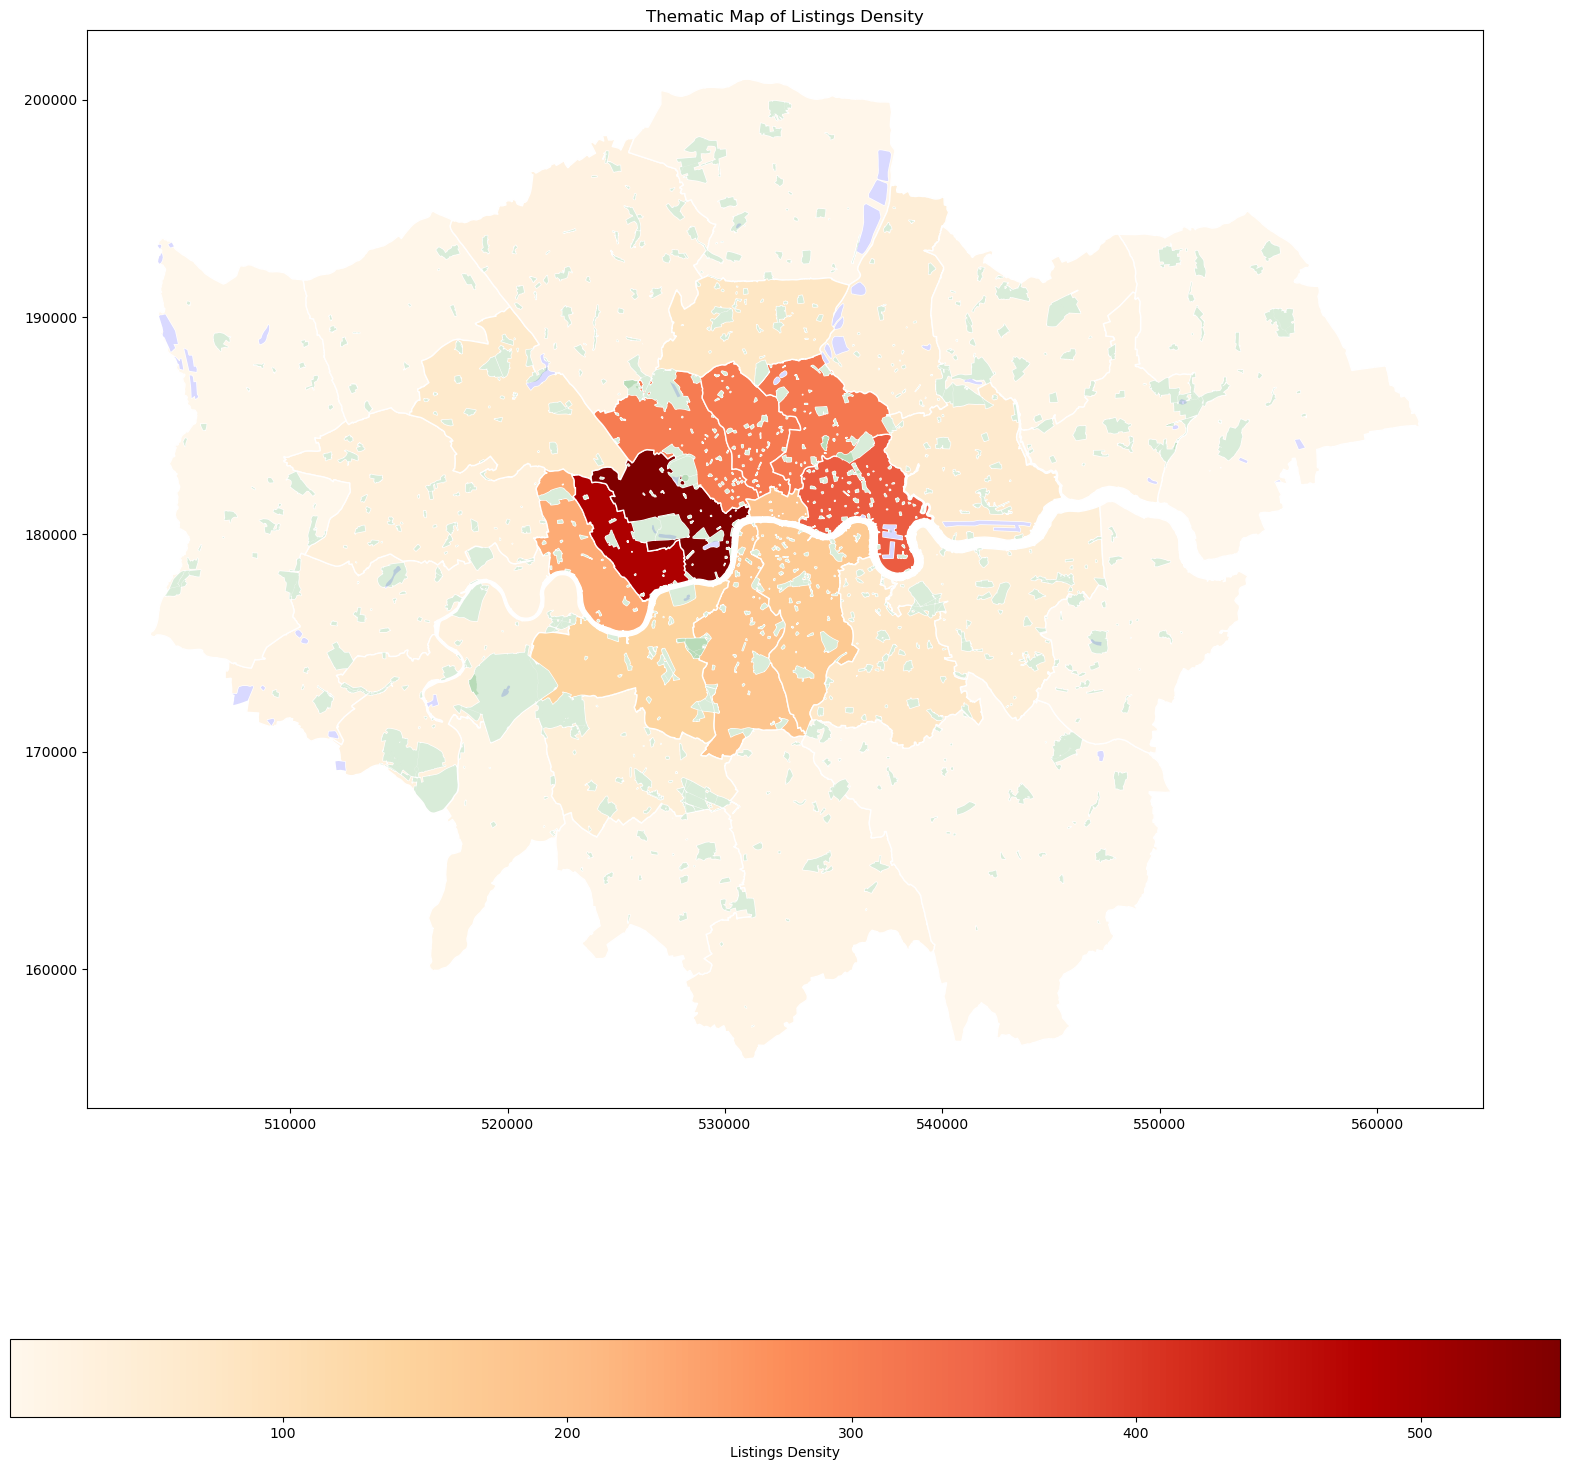

In [57]:
clip_water = water.clip(boros.union_all())


fig, ax = plt.subplots(figsize=(20, 20))

new_boros.plot(ax=ax, 
               column='listing_density', 
               cmap='OrRd',  # Choose a color map
               edgecolor='white',  # Color of the borders
               legend=True,  # Show legend
               legend_kwds={'label': "Listings Density", 'orientation': "horizontal"})
clip_water.plot(ax=ax, color = 'blue', alpha = 0.15)
green.plot(ax=ax, color = 'green', alpha = 0.15)

plt.title('Thematic Map of Listings Density')
plt.show()


In [40]:
sort_boros = new_boros.sort_values(by='listing_density', ascending = False)

print(sort_boros[['NAME', 'listing_count', 'area', 'listing_density']])

                      NAME  listing_count        area  listing_density
24             Westminster           9504   17.309994       549.046982
23  Kensington and Chelsea           5663   11.589501       488.631930
26           Tower Hamlets           6271   17.581099       356.689865
28                 Hackney           5494   17.672516       310.878198
27               Islington           4464   14.382121       310.385365
25                  Camden           5520   18.124477       304.560518
22  Hammersmith and Fulham           3589   15.371708       233.480880
32          City of London            546    2.894712       188.619778
10                 Lambeth           4483   24.795601       180.798199
11               Southwark           4562   26.964643       169.184510
21              Wandsworth           4263   30.650573       139.083858
29                Haringey           2123   27.647382        76.788464
12                Lewisham           2350   32.845350        71.547417
8     

In [41]:
new_boros['listing_percent'] = (new_boros['listing_count']/new_boros['listing_count'].sum())*100
new_boros['listing_percent'] = new_boros['listing_percent'].round(2)

In [42]:
print(new_boros[['NAME','listing_percent']])

                      NAME  listing_percent
0     Kingston upon Thames             0.74
1                  Croydon             1.73
2                  Bromley             0.96
3                 Hounslow             1.42
4                   Ealing             2.38
5                 Havering             0.52
6               Hillingdon             0.98
7                   Harrow             0.63
8                    Brent             3.18
9                   Barnet             2.56
10                 Lambeth             5.41
11               Southwark             5.51
12                Lewisham             2.84
13               Greenwich             2.31
14                  Bexley             0.59
15                 Enfield             0.92
16          Waltham Forest             2.07
17               Redbridge             1.04
18                  Sutton             0.46
19    Richmond upon Thames             1.43
20                  Merton             1.68
21              Wandsworth      

In [43]:
print(len(df['host_id']))
print(df['host_id'].nunique())

84702
49319


In [44]:
abnb_2010 = abnb[abnb['host_since'] < '2010-01-01']
abnb_2015 = abnb[abnb['host_since'] < '2015-01-01']
abnb_2020 = abnb[abnb['host_since'] < '2020-01-01']

print(f"Number of listings in London till 2010: {len(abnb_2010)}")
print(f"Number of listings in London till 2015: {len(abnb_2015)}")
print(f"Number of listings in London till 2020: {len(abnb_2020)}")
print(f"Number of listings in London till 2024: {len(abnb)}")



Number of listings in London till 2010: 113
Number of listings in London till 2015: 22119
Number of listings in London till 2020: 63194
Number of listings in London till 2024: 84702


In [45]:
joined_2010 = gpd.sjoin(abnb_2010, new_boros, how="inner", predicate="within")

listing_counts = joined_2010.groupby('NAME').size().reset_index(name='listing_count_2010')

new_boros = new_boros.merge(listing_counts, on='NAME', how='left')

In [46]:
joined_2015 = gpd.sjoin(abnb_2015, new_boros, how="inner", predicate="within")

listing_counts = joined_2015.groupby('NAME').size().reset_index(name='listing_count_2015')

new_boros = new_boros.merge(listing_counts, on='NAME', how='left')

In [47]:
joined_2020 = gpd.sjoin(abnb_2020, new_boros, how="inner", predicate="within")

listing_counts = joined_2020.groupby('NAME').size().reset_index(name='listing_count_2020')

new_boros = new_boros.merge(listing_counts, on='NAME', how='left')

In [48]:
new_boros[['listing_count_2010', 'listing_count_2015', 'listing_count_2020', 'listing_count']] = new_boros[['listing_count_2010', 'listing_count_2015', 'listing_count_2020', 'listing_count']].fillna(0)

In [49]:
print(new_boros)

                      NAME   GSS_CODE  OLD_HECTARES        area  \
0     Kingston upon Thames  E09000021      3726.117   36.877045   
1                  Croydon  E09000008      8649.441   84.223229   
2                  Bromley  E09000006     15013.487  146.182312   
3                 Hounslow  E09000018      5658.541   50.729313   
4                   Ealing  E09000009      5554.428   53.596711   
5                 Havering  E09000016     11445.735  107.080519   
6               Hillingdon  E09000017     11570.063  110.374332   
7                   Harrow  E09000015      5046.330   49.509380   
8                    Brent  E09000005      4323.270   40.363930   
9                   Barnet  E09000003      8674.837   82.907182   
10                 Lambeth  E09000022      2724.940   24.795601   
11               Southwark  E09000028      2991.340   26.964643   
12                Lewisham  E09000023      3531.706   32.845350   
13               Greenwich  E09000011      5044.190   43.62508

In [50]:
new_boros['listing_percent_change_2015'] = ((new_boros['listing_count_2015']-new_boros['listing_count_2010'])/new_boros['listing_count_2015'].sum())*100
new_boros['listing_percent_change_2015'] = new_boros['listing_percent_change_2015'].round(2)

In [51]:
new_boros['listing_percent_change_2020'] = ((new_boros['listing_count_2020']-new_boros['listing_count_2015'])/new_boros['listing_count_2020'].sum())*100
new_boros['listing_percent_change_2020'] = new_boros['listing_percent_change_2020'].round(2)

In [52]:
new_boros['listing_percent_change_2025'] = ((new_boros['listing_count']-new_boros['listing_count_2020'])/new_boros['listing_count'].sum())*100
new_boros['listing_percent_change_2025'] = new_boros['listing_percent_change_2025'].round(2)

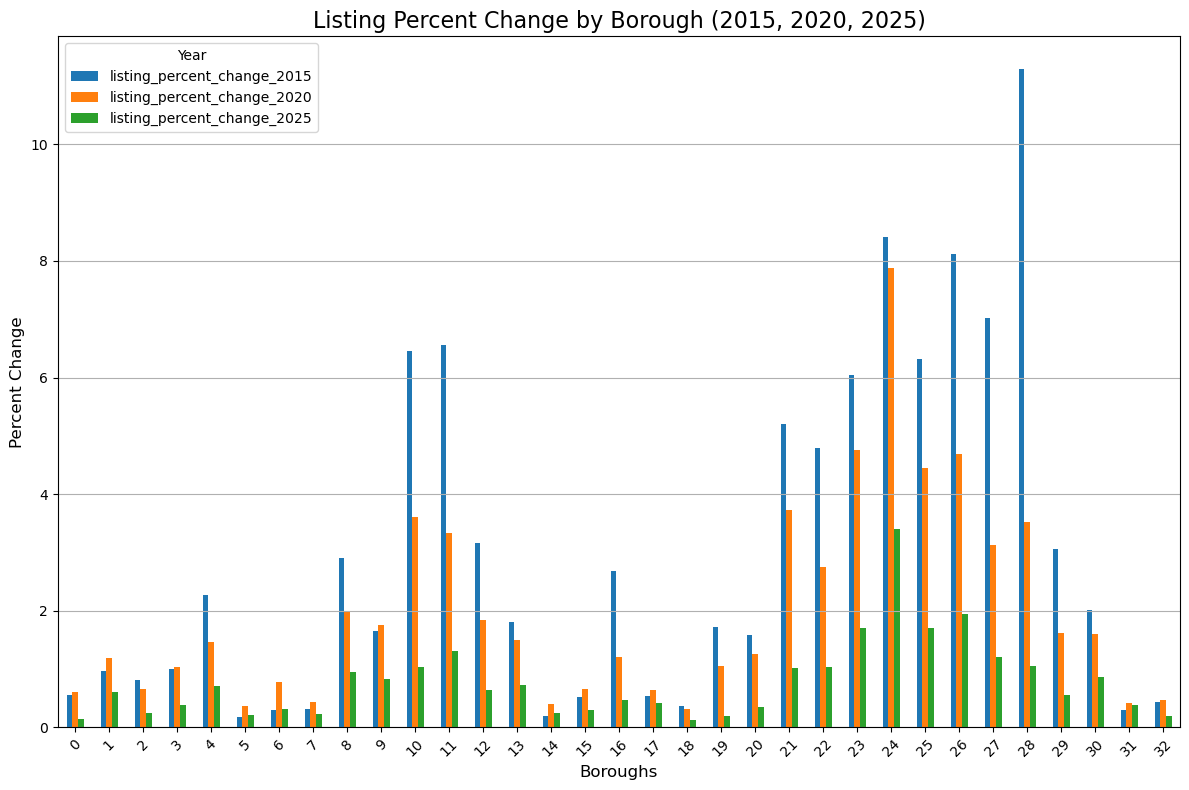

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

# Step 3: Prepare data for plotting
# Set the index to borough names for easier plotting
new_boros.set_index('NAME', inplace=False)

# Step 4: Create bar graphs
# Plotting the data for each year
new_boros[['listing_percent_change_2015', 'listing_percent_change_2020', 'listing_percent_change_2025']].plot(kind='bar', ax=ax)

# Step 5: Customize the plot
ax.set_title('Listing Percent Change by Borough (2015, 2020, 2025)', fontsize=16)
ax.set_xlabel('Boroughs', fontsize=12)
ax.set_ylabel('Percent Change', fontsize=12)
ax.legend(title='Year', fontsize=10)
ax.grid(axis='y')

# Step 6: Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

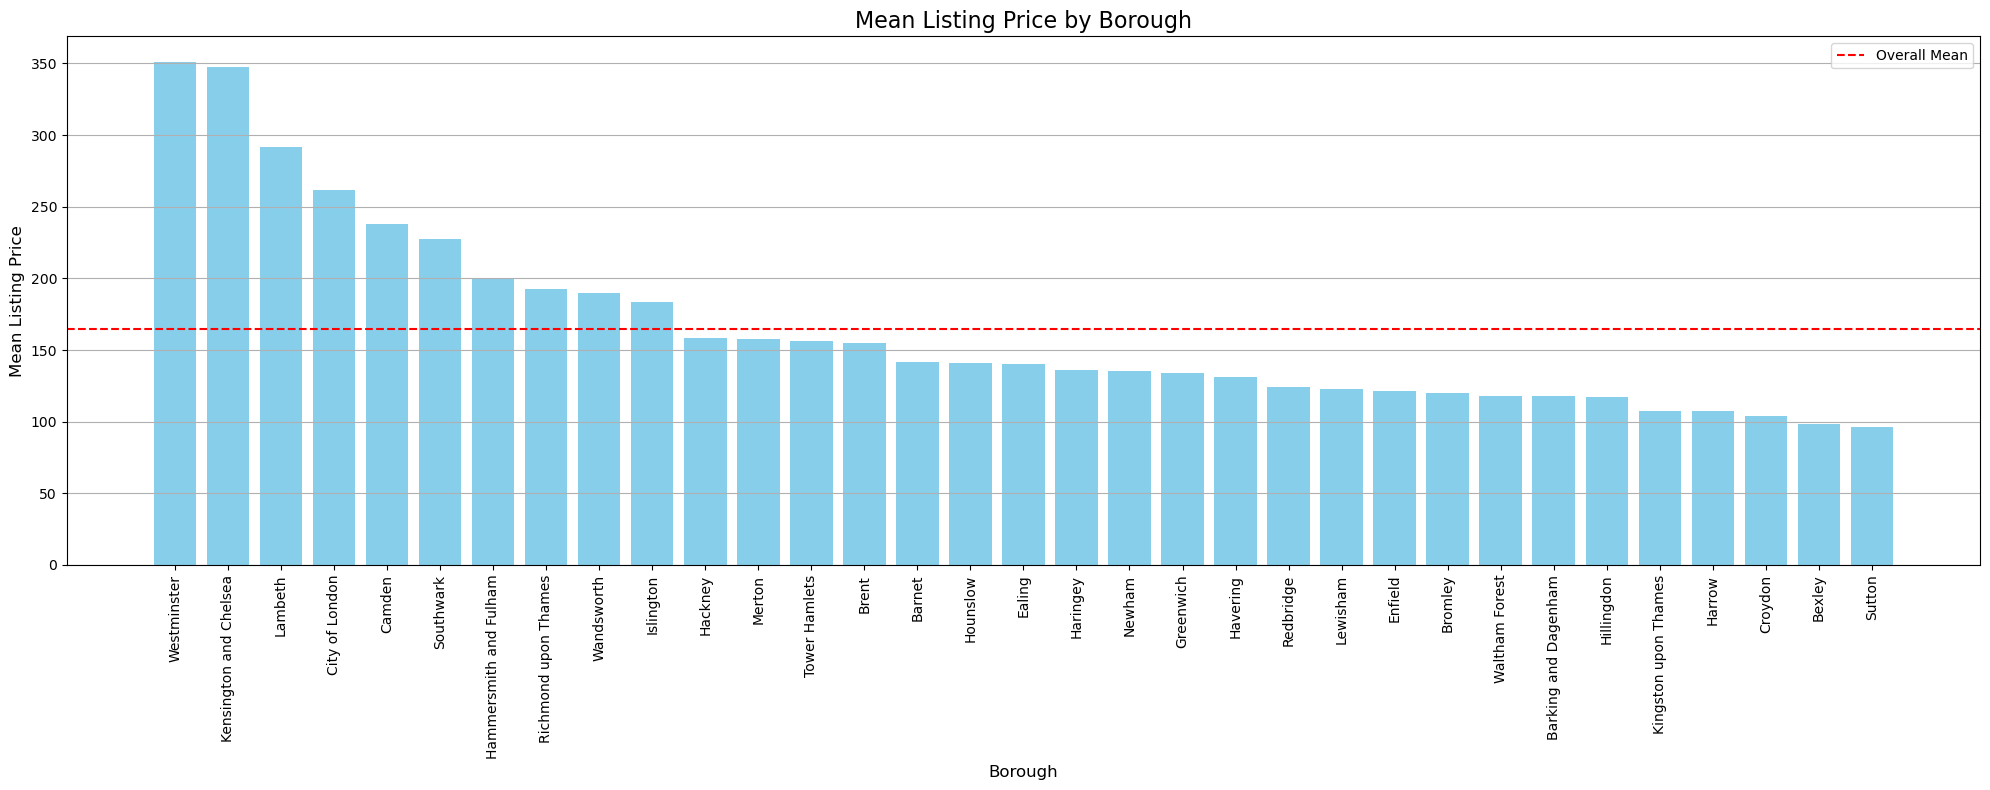

In [82]:
mean_prices = joined.groupby('NAME')['price'].mean().reset_index()
mean_prices.columns = ['borough', 'mean_listing_price']
mean_prices['mean_listing_price'] = mean_prices['mean_listing_price'].round(2)

mean_prices = mean_prices.sort_values(by ='mean_listing_price', ascending = False)

overall_mean = mean_prices['mean_listing_price'].mean()


plt.figure(figsize=(20, 8))
plt.bar(mean_prices['borough'], mean_prices['mean_listing_price'], color='skyblue')
plt.title('Mean Listing Price by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Mean Listing Price', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y')

plt.axhline(y=overall_mean, color='red', linestyle='--', label='Overall Mean')
plt.legend()

#Show the plot
plt.tight_layout()
plt.show()


In [83]:
print(mean_prices)
print(sort_boros[['NAME', 'listing_count', 'listing_density']])

                   borough  mean_listing_price
32             Westminster              351.31
19  Kensington and Chelsea              347.18
21                 Lambeth              291.44
6           City of London              261.84
5                   Camden              237.67
27               Southwark              227.69
12  Hammersmith and Fulham              200.06
26    Richmond upon Thames              192.46
31              Wandsworth              189.51
18               Islington              183.34
11                 Hackney              158.39
23                  Merton              157.36
29           Tower Hamlets              156.41
3                    Brent              155.04
1                   Barnet              141.45
17                Hounslow              140.81
8                   Ealing              139.89
13                Haringey              136.00
24                  Newham              135.20
10               Greenwich              133.63
15           

In [96]:
westminster_boro = joined[joined['NAME'] == 'Westminster']
print(westminster_boro.head())

                      id                                       listing_url  \
90              52159332             https://www.airbnb.com/rooms/52159332   
92   1066435651558414464  https://www.airbnb.com/rooms/1066435651558414408   
114   755595982137126784   https://www.airbnb.com/rooms/755595982137126722   
131  1130264463622053504  https://www.airbnb.com/rooms/1130264463622053478   
135   774061637963678208   https://www.airbnb.com/rooms/774061637963678253   

       host_id   host_name  host_since            host_location  \
90   285728582   Valentina  2019-08-14  England, United Kingdom   
92   457717158  James & Co  2022-05-06                      NaN   
114  486779839      Marius  2022-11-07   London, United Kingdom   
131  425073204        Cuba  2021-09-28                      NaN   
135   10370524   Be London  2013-12-01                      NaN   

                                            host_about  host_is_superhost  \
90   I appreciate all the simple thing in life, fam

/tmp/ipykernel_40371/1201130377.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


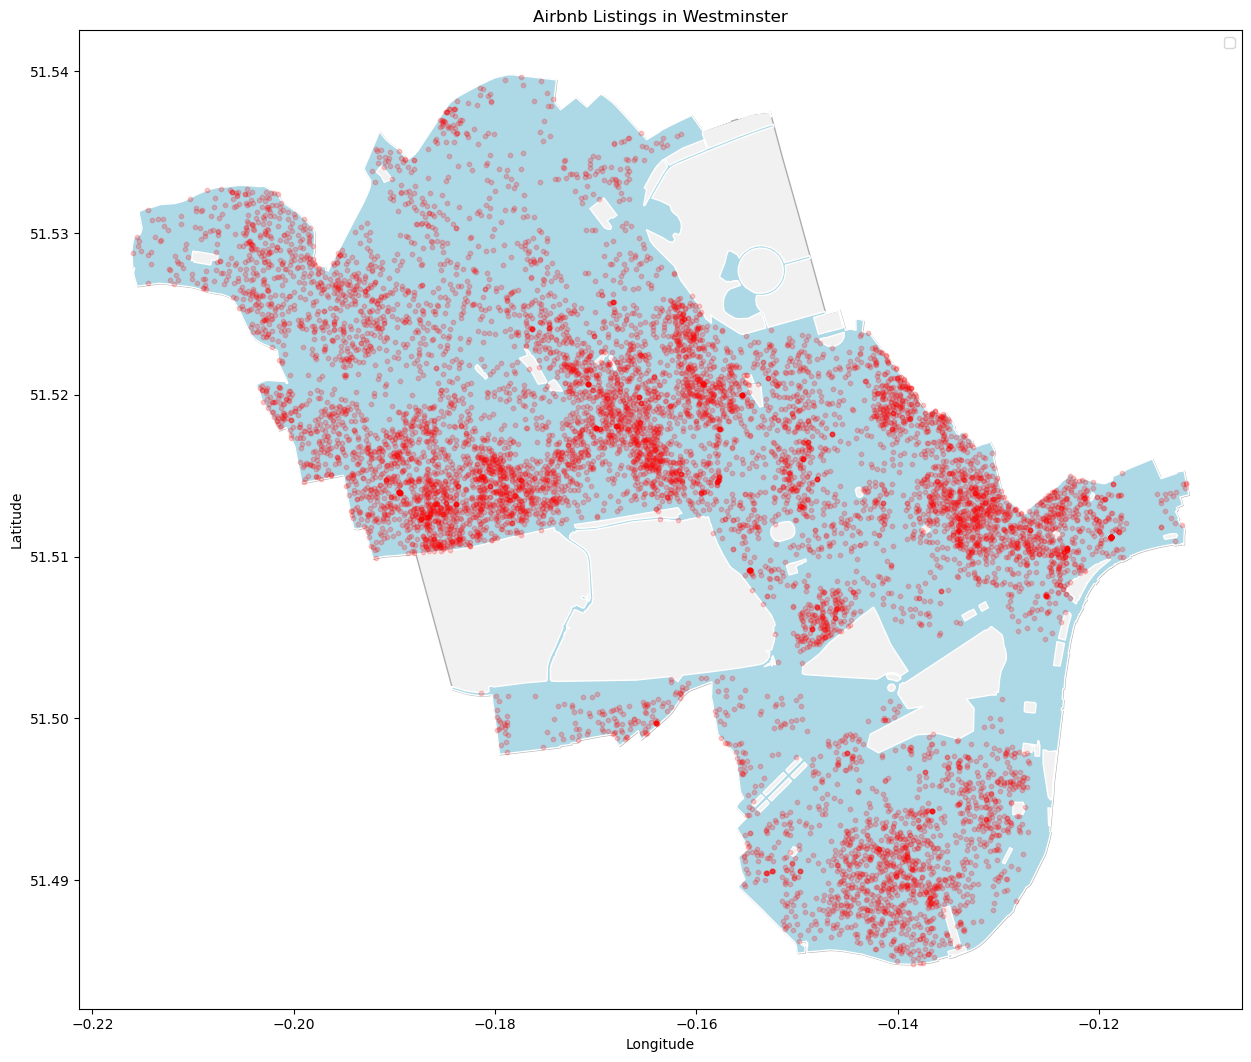

In [113]:
geometry_westminster = gpd.points_from_xy(westminster_boro['longitude'], westminster_boro['latitude'])
westminster_bnb = gpd.GeoDataFrame (westminster_boro, geometry = geometry_westminster, crs="EPSG:4326")

westminster_boundary = new_boros[new_boros['NAME'] == 'Westminster']
westminster_bg = boros[boros['NAME'] == 'Westminster']

westminster_boundary = westminster_boundary.to_crs(westminster_bnb.crs)
westminster_bg = westminster_bg.to_crs(westminster_bnb.crs)

fig, ax = plt.subplots(figsize=(15, 15))

# Plot the Westminster boundary
westminster_bg.plot(ax=ax, color = 'lightgrey', edgecolor = 'black', alpha = 0.3)
westminster_boundary.plot(ax=ax, color='lightblue', edgecolor='white')

# Plot the Airbnb listings
westminster_bnb.plot(ax=ax, marker='o', color='red', markersize=10, alpha=0.2)  # Adjust markersize and alpha as needed

# Add labels and title
ax.set_title("Airbnb Listings in Westminster")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()


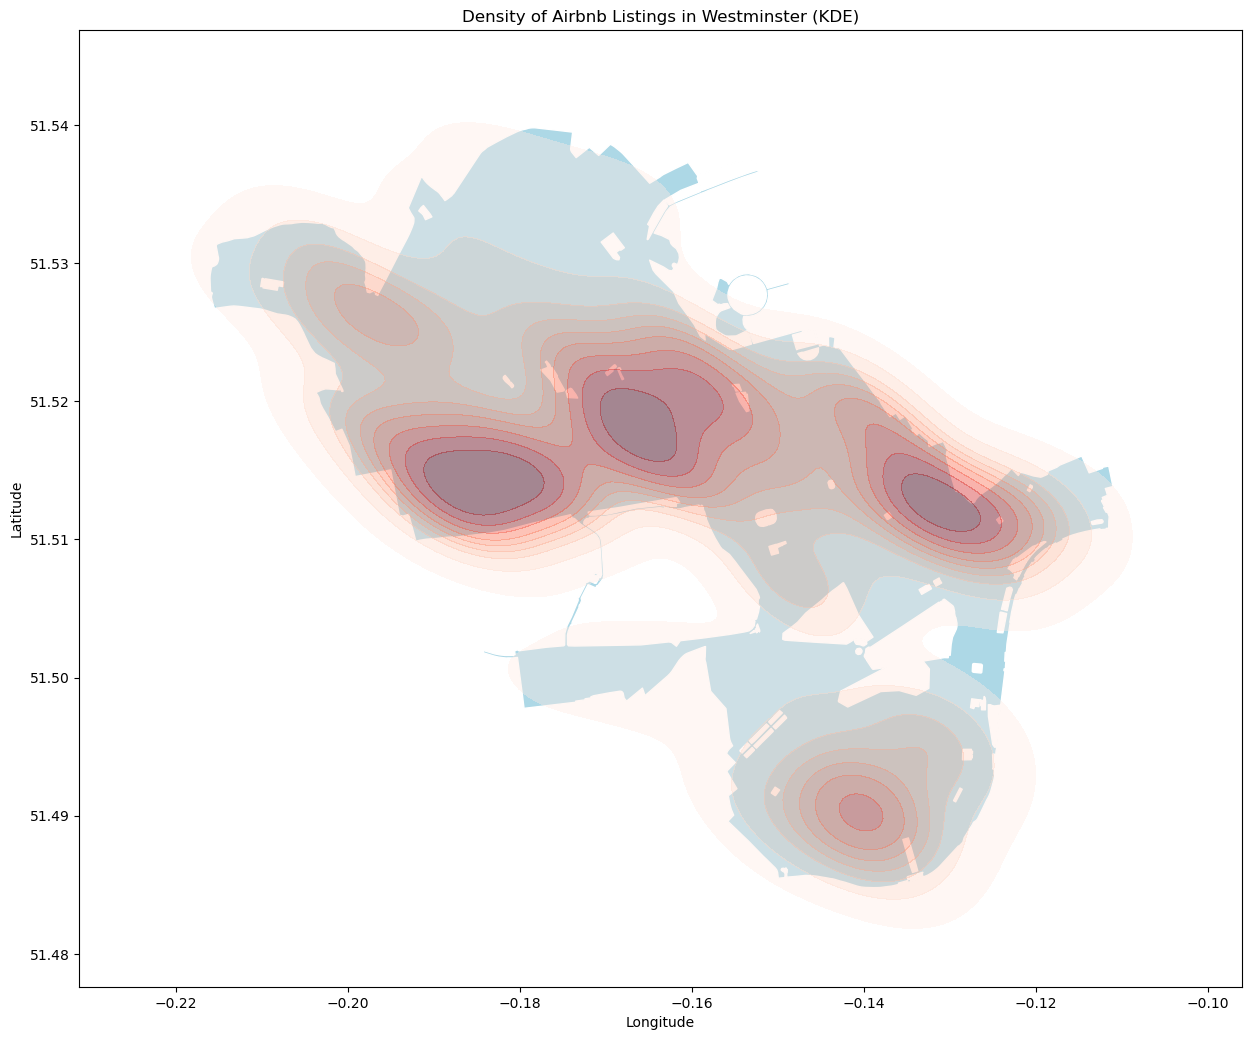

In [122]:
fig, ax = plt.subplots(figsize=(15, 15))

westminster_boundary.plot(ax=ax, color='lightblue', edgecolor='white')
sns.kdeplot(x=westminster_bnb['longitude'], y=westminster_bnb['latitude'],
            cmap="Reds", fill=True, thresh=0.02, ax=ax, alpha = 0.4)

ax.set_title("Density of Airbnb Listings in Westminster (KDE)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


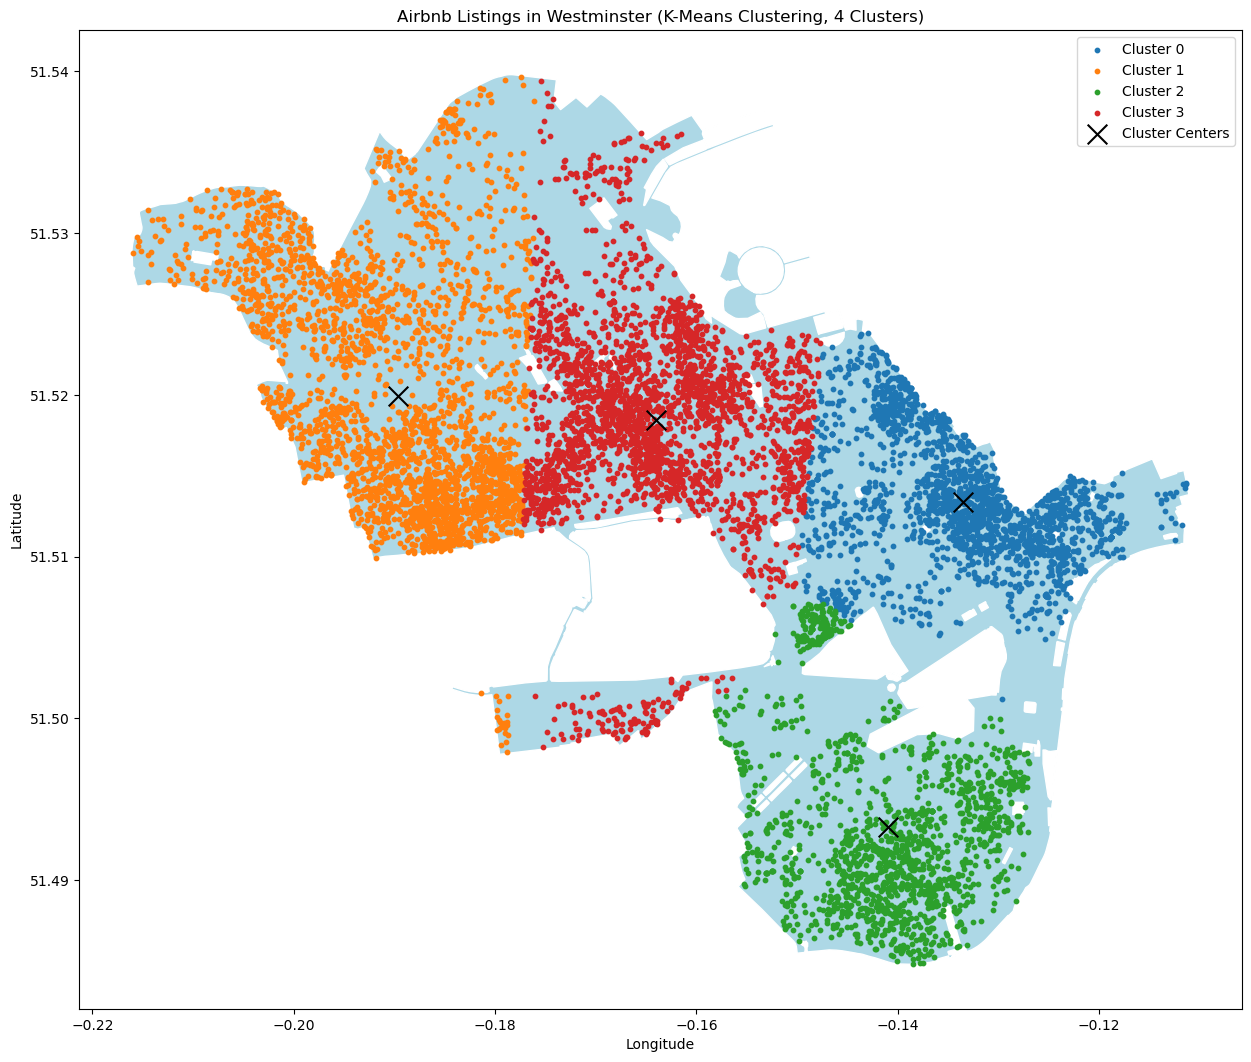

In [126]:
coords = np.array(list(zip(westminster_bnb.geometry.x, westminster_bnb.geometry.y)))

# Apply K-Means clustering
n_clusters = 4  # Set the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto') #n_init added to remove warning
westminster_bnb['cluster'] = kmeans.fit_predict(coords)

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the Westminster background and boundary
westminster_boundary.plot(ax=ax, color='lightblue', edgecolor='white')

# Plot the clusters
for cluster in range(n_clusters):
    cluster_points = westminster_bnb[westminster_bnb['cluster'] == cluster]
    cluster_points.plot(ax=ax, marker='o', markersize=10, label=f"Cluster {cluster}")

# Plot cluster centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, color='black', label='Cluster Centers')

# Add labels, title, and legend
ax.set_title(f"Airbnb Listings in Westminster (K-Means Clustering, {n_clusters} Clusters)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()


In [130]:
print(westminster_bnb['cluster'].head())

90     2
92     2
114    2
131    1
135    1
Name: cluster, dtype: int32


In [132]:
duplicate_counts = (
    westminster_bnb.groupby(['cluster', 'host_id'])
    .size()  # Count occurrences of each host_id in each cluster
    .reset_index(name='count'))

duplicates_per_cluster = duplicate_counts[duplicate_counts['count'] > 1]

duplicate_summary = duplicates_per_cluster.groupby('cluster').size().reset_index(name='duplicate_host_count')

print(duplicate_summary)



   cluster  duplicate_host_count
0        0                   291
1        1                   371
2        2                   210
3        3                   415
